## Machine learning Model

* in this file we will be attempting to create a Machine Learning model that is able to identify and predict SYN flood from normal network communication.

### Model Pseudocode

In [ ]:
# BEGIN

# 1. Load dataset
#    - Separate features (X) and labels (y)

# 2. Set up 5-fold cross-validation
#    - Use StratifiedKFold to maintain class balance

# 3. Define SVM model with:
#    - RBF kernel
#    - C = 10.0
#    - gamma = 'auto'
#    - class_weight = 'balanced'

# 4. For each fold:
#    a. Split data into training and validation sets
#    b. Train SVM on training set
#    c. Predict on validation set
#    d. Evaluate performance (e.g. accuracy)
#    e. Save results

# 5. Calculate and print average accuracy across all folds

# END


## Step1: Select and Load the Dataset

In [2]:
import pandas as pd

# Load the preprocessed and normalized dataset
df = pd.read_csv('D:\Coding Projects\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\Data\K5_Dataset.csv')

# Separate features and label
X = df.drop('Label', axis=1)
y = df['Label']

# Check the shapes
print(f'Features shape: {X.shape}')
print(f'Labels shape: {y.shape}')

Features shape: (9604, 13)
Labels shape: (9604,)


## Step 2: Define SVM Model and Hyperparameters    

In [3]:
from sklearn.svm import SVC

# # Define the SVM model with extended hyperparameters (using default values for now)
# svm_model = SVC(
#     C=1.0,              # Regularization parameter
#     kernel='rbf',       # Kernel type: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
#     gamma='scale',      # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     shrinking=True,     # Whether to use the shrinking heuristic
#     probability=False,  # Enable probability estimates (slower)
#     tol=1e-3,           # Tolerance for stopping criterion
#     cache_size=500,     # Size of the kernel cache (in MB)
#     class_weight=None,  # Set the parameter for unbalanced classes
#     decision_function_shape='ovr',  # 'ovo' or 'ovr'
#     random_state=None   # Set for reproducibility
# )


svm_model = SVC(
    C=10.0,               
    kernel='rbf',         
    gamma='auto',           
    class_weight=None,    
    probability=True,      
    cache_size=500,
    tol=1e-4,              
    shrinking=True,
    decision_function_shape='ovr',
    random_state=42
)


## Step 3: Model Training with Cross-Validation + Resource Management

In [8]:
import time
import psutil
import os
from sklearn.metrics import accuracy_score

fold_accuracies = []
all_y_true = []
all_y_pred = []
all_y_scores = []

process = psutil.Process(os.getpid())

# Resource Monitoring Start 
overall_start_time = time.time()
overall_start_ram = process.memory_info().rss / 1024 / 1024  # in MB
overall_start_cpu = psutil.cpu_percent(interval=1)

for fold in range(0, 5): 
    print(f'\nTraining fold {fold}...')

    train_idx = df[df['Fold'] != fold].index
    val_idx = df[df['Fold'] == fold].index

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model
    svm_model.fit(X_train, y_train)

    # Predict
    y_pred = svm_model.predict(X_val)
    y_scores = svm_model.decision_function(X_val)

    # Store results
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    all_y_scores.extend(y_scores)

    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f'Fold {fold} Accuracy: {acc:.4f}')

# Resource Monitoring End
overall_end_time = time.time()
overall_end_ram = process.memory_info().rss / 1024 / 1024  # in MB
overall_end_cpu = psutil.cpu_percent(interval=1)

# Summary 
print("\nOverall SVM Training Stats")
print(f"Total Training Time: {overall_end_time - overall_start_time:.2f} seconds")
print(f"Total RAM Usage Increase: {overall_end_ram - overall_start_ram:.2f} MB")
print(f"CPU Usage (at final check): {overall_end_cpu}%")



Training fold 0...
Fold 0 Accuracy: 0.9282

Training fold 1...
Fold 1 Accuracy: 0.9256

Training fold 2...
Fold 2 Accuracy: 0.9297

Training fold 3...
Fold 3 Accuracy: 0.9261

Training fold 4...
Fold 4 Accuracy: 0.9250

Overall SVM Training Stats
Total Training Time: 47.66 seconds
Total RAM Usage Increase: 0.04 MB
CPU Usage (at final check): 9.8%


## Step 4: Model Evaluation  

In [5]:
import numpy as np

print("\nFinal SVM Cross-Validation Results:")
print(f'Accuracies from each fold: {fold_accuracies}')
print(f'Average Accuracy: {np.mean(fold_accuracies):.4f}')
print(f'Standard Deviation: {np.std(fold_accuracies):.4f}')



Final SVM Cross-Validation Results:
Accuracies from each fold: [0.9281624154086413, 0.9255596043727226, 0.9297241020301926, 0.9260801665799063, 0.925]
Average Accuracy: 0.9269
Standard Deviation: 0.0018


## Step 5: Visual Evaluation 

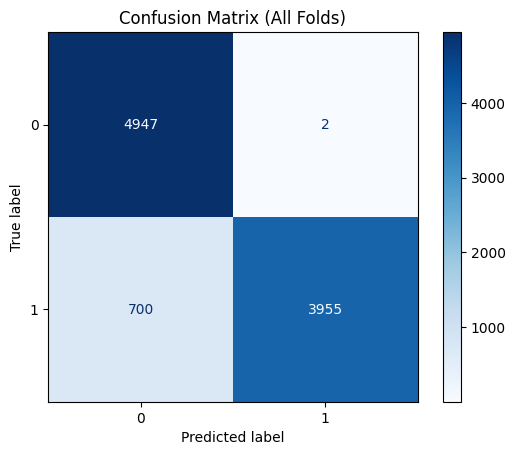

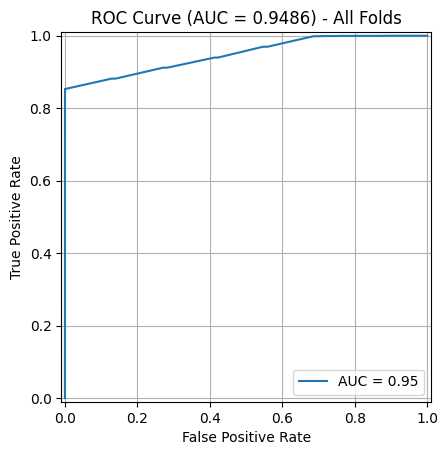

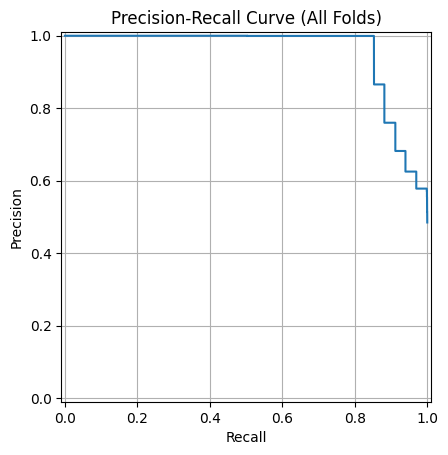

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

# Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_cm.plot(cmap='Blues')
plt.title('Confusion Matrix (All Folds)')
plt.grid(False)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_y_true, all_y_scores)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f'ROC Curve (AUC = {roc_auc:.4f}) - All Folds')
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_y_true, all_y_scores)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision-Recall Curve (All Folds)')
plt.grid(True)
plt.show()
